In [1]:
import qevo
from qevo import *

In [2]:
def swap(probs, targets, N):
    axes = list(range(N))
    axes[targets[0]], axes[targets[1]] = axes[targets[1]], axes[targets[0]]
    return np.transpose(probs, axes)

class SWAP(Operation):
    def __init__(self, targets, N, P2):
        self.targets = [max(targets)-1, max(targets)] # an ugly hack so that old logic can be used
        self.N = N
        self.P2 = P2
    def __eq__(self, other):
        return type(other) is SWAP and self.targets == other.targets
    def __hash__(self):
        return hash((SWAP, tuple(self.targets), self.N))
    def strs(self):
        return ['-x-' if _ == self.targets[0]
                else '-x-' if _ == self.targets[1]
                else '-|-' if min(self.targets)<_<max(self.targets)
                else '---'
                for _ in range(self.N)]
    def __str__(self):
        return 'SWAP(%s, %s, %s)'%(self.targets, self.N, self.P2)
    #TODO
    def apply(self, probs):
        return depolarize2(swap(probs, self.targets, self.N), self.targets, self.P2)
    def apply_sym(self, probs):
        return depolarize2_sym(swap(probs, self.targets, self.N), self.targets, self.P2)
    @classmethod
    def random(cls, N, F, P2, Mη, qs=None):
        return cls(random.sample(range(N),2), N, P2)
    def mutate(self):
        return SWAP(random.sample(range(self.N),2), self.N, self.P2)
    def copy(self, F=None, P2=None, Mη=None):
        return SWAP(self.targets.copy(), self.N,
                    P2=P2 if P2 else self.P2)
    def rearrange(self, permutation_dict):
        r = self.copy()
        r.targets[0] = permutation_dict[r.targets[0]]
        r.targets[1] = permutation_dict[r.targets[1]]
        return r
    @property
    def args(self):
        return self.targets, self.N, self.P2
    
class ComReset(Measurement):
    def __init__(self, N, F, Mη, qs=None):
        self.target = N-1
        self.N = N
        self.F = F
        self.Mη = Mη
        self.qs = qs
        self.pair = [0,0] # XXX meaningless filler so that the plotter does not go crazy
    def __eq__(self, other):
        return type(other) is ComReset and self.target == other.target
    def __hash__(self):
        return hash((ComReset, self.N))
    def strs(self):
        return ['-#>'
                if _ == self.target else '---'
                for _ in range(self.N)]
    def __str__(self):
        return 'ComReset(%s, %s, %s, %s)'%(self.N, self.F, self.Mη, self.qs)
    def apply(self, probs):
        probs_meas = np.sum(probs, axis=self.target)
        F = self.F
        q = [(1-F)/3]*3 if self.qs is None else self.qs
        slices = [slice(None)]*self.N
        for i, f in zip(range(4),(F,*q)):
            slices[self.target] = i
            probs[tuple(slices)] = probs_meas*f
        return probs
    def apply_sym(self, probs, separate_F=False):
        raise NotImplementedError
    def succ_prob(self, probs):
        return 1.
    @classmethod
    def random(cls, N, F, P2, Mη, qs=None):
        return cls(N, F, Mη, qs)
    def mutate(self):
        return self.copy()
    def copy(self, F=None, P2=None, Mη=None, qs=None):
        return ComReset(self.N,
                        F=F if F else self.F,
                        Mη=Mη if Mη else self.Mη,
                        qs=qs if qs else self.qs)
    @property
    def args(self):
        return self.N, self.F, self.Mη

Let's see all possible permutations of single-qubit gates on the Nigmatullin's circuit.

In [4]:
zmeas = lambda t: Measurement(t, [0, 3], 3, 0.9, 0.99, None)
cnot = lambda t: CNOT([t-1,t], 3, 0.99)
s = lambda t: SWAP([t-1,t], 3, 0.99)
reset = lambda : ComReset(3, 0.9, 0.99)
circuits = [Individual(F=0.9, ops=[
    s(2),
    reset(),
    cnot(2),
    zmeas(2),
    s(1),
    
    s(2),
    reset(),
    cnot(2),
    zmeas(2),
    CNOTPerm([0,1],[0,*p1],[0,*p2],3,0.99),
    zmeas(1),
    
    s(2),
    reset(),
    cnot(2),
    CNOTPerm([0,1],[0,*p3],[0,*p4],3,0.99),
    zmeas(2),
    zmeas(1)
    
]) for p1, p2, p3, p4 in list(itertools.product(itertools.permutations([1,2,3]),repeat=4))]
fids = [_.fidelity_and_succ_prob()[0] for _ in circuits]
max(fids), fids.count(max(fids))

(0.9754452108342371, 8)

In [5]:
circuits = [Individual(F=0.9, ops=[
    s(2),
    reset(),
    cnot(2),
    zmeas(2),
    s(1),
    
    s(2),
    reset(),
    cnot(2),
    zmeas(2),
    CNOTPerm([0,1],[0,1,3,2],[0,1,3,2],3,0.99),
    zmeas(1),
    
    s(2),
    reset(),
    cnot(2),
    CNOTPerm([0,1],[0,*p3],[0,*p4],3,0.99),
    zmeas(2),
    zmeas(1)
    
]) for p3, p4 in list(itertools.product(itertools.permutations([1,2,3]),repeat=2))]
fids = [_.fidelity_and_succ_prob()[0] for _ in circuits]
max(fids), fids.count(max(fids))

(0.975445210834237, 4)

In [6]:
fids.index(max(fids)), fids.index(max(fids), fids.index(max(fids))+1)

(19, 21)

In [7]:
list(itertools.product(itertools.permutations([1,2,3]),repeat=2))[19]

((2, 3, 1), (1, 3, 2))

In [8]:
list(itertools.product(itertools.permutations([1,2,3]),repeat=2))[21]

((2, 3, 1), (2, 3, 1))

The one from their paper is as good as the other 7 in its equivalence class.

In [9]:
nigmatullin = Individual(F=0.9, ops=[
    s(2),
    reset(),
    cnot(2),
    zmeas(2),
    s(1),
    
    s(2),
    reset(),
    cnot(2),
    zmeas(2),
    CNOTPerm([0,1],[0,1,3,2],[0,1,3,2],3,0.99),
    zmeas(1),
    
    s(2),
    reset(),
    cnot(2),
    CNOTPerm([0,1],[0,2,3,1],[0,2,3,1],3,0.99),
    zmeas(2),
    zmeas(1)
])

In [10]:
nigmatullin.fidelity_and_succ_prob()

(0.975445210834237, 0.43194787567430243)

In [10]:
print(str(nigmatullin))

----------------x----------------*o----------------*o-------------
-x-----o--------x--x-----o-------*X--D03 >-x-----o-*X--------D03 >
-x--#>-X--D03 >----x--#>-X--D03 >----------x--#>-X-----D03 >------


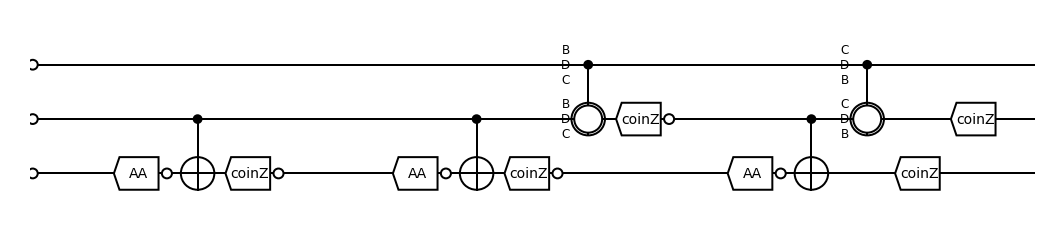

In [11]:
individual2plot(nigmatullin);

Now we can try to find a better circuit from scratch. We will look at 3 different possible lengths. Plotting will work poorly as most of the code is not written to be used as a library.

In [11]:
class AMeasurementNoReset(AMeasurement):
    def __eq__(self, other):
        return type(other) is AMeasurementNoReset and self.target == other.target and self.other == other.other
    def __hash__(self):
        return hash((AMeasurementNoReset, self.target, self.other, self.N))
    def __str__(self):
        return 'AMeasurementNoReset(%s, %s, %s, %s, %s, %s)'%(self.target, self.other,
                                                       self.N, self.F, self.Mη,
                                                       self.qs)
    def mutate(self):
        return AMeasurementNoReset(self.target, random.choice([1,2,3]),
                           self.N, self.F, self.Mη, self.qs)
    def copy(self, F=None, P2=None, Mη=None, qs=None):
        return AMeasurementNoReset(self.target, self.other, self.N,
                           F=F if F else self.F,
                           Mη=Mη if Mη else self.Mη,
                           qs=qs if qs else self.qs)
    def apply(self, probs):
        if self.target == self.N-1:
            return measure(probs, self.target, self.pair, self.N, self.F, self.Mη, qs=self.qs)
        else:
            return measure(probs, self.target, self.pair, self.N, 0.25, self.Mη)
        
class CNOTPermNeigh(CNOTPerm):
    def __init__(self, targets, permcontrol, permtarget, N, P2):
        self.targets = [max(targets)-1, max(targets)] # an ugly hack so that old logic can be used
        self.N = N
        self.P2 = P2
        self.permcontrol = tuple(permcontrol)
        self.permtarget = tuple(permtarget)
    def __eq__(self, other):
        return type(other) is CNOTPermNeigh and self.targets == other.targets and self.permcontrol == other.permcontrol and self.permtarget == self.permtarget
    def __hash__(self):
        return hash((CNOTPermNeigh, tuple(self.targets), self.permcontrol, self.permtarget, self.N))
    def __str__(self):
        return 'CNOTPermNeigh(%s, %s, %s, %s, %s)'%(self.targets, self.permcontrol, self.permtarget, self.N, self.P2)
    def copy(self, F=None, P2=None, Mη=None):
        return CNOTPermNeigh(self.targets.copy(), self.permcontrol, self.permtarget, self.N,
                        P2=P2 if P2 else self.P2)

In [12]:
def get_new_probs_hotcold(N, F, qs=None):
    lF = np.log(F)
    q = (1-F)/3
    lq = np.log(q)
    lqs = [lq]*3
    bads = np.log([0.25]*4)
    probs = np.empty((4,)*N)
    for i, p in zip(itertools.product(range(4),   repeat=N),
                    itertools.product(*([bads]*(N-1)+[(lF, *lqs)]))):
        probs[i] = np.exp(sum(p))
    return probs
qevo.get_new_probs = get_new_probs_hotcold

In [13]:
conf = default_config.copy()
conf['MAX_OPS'] = 19
conf['STARTING_OPS'] = 15
conf['N'] = 3
conf['POPULATION_SIZE'] = 1000
conf['STARTING_POP_MULTIPLIER'] = 10
conf['MAX_GEN'] = 2000
conf['PERMITTED_OPS'] = [CNOTPermNeigh, AMeasurementNoReset, SWAP, ComReset]
conf

OrderedDict([('N', 3),
             ('F', 0.9),
             ('P2', 0.99),
             ('Mη', 0.99),
             ('WEIGHTS', (1, 0)),
             ('STARTING_OPS', 15),
             ('MAX_OPS', 19),
             ('PERMITTED_OPS',
              [__main__.CNOTPermNeigh,
               __main__.AMeasurementNoReset,
               __main__.SWAP,
               __main__.ComReset]),
             ('POPULATION_SIZE', 1000),
             ('STARTING_POP_MULTIPLIER', 10),
             ('MUTANTS_PER_INDIVIDUAL_PER_TYPE', 1),
             ('P_ADD_OPERATION', 0.7),
             ('P_LOSE_OPERATION', 0.9),
             ('P_SWAP_OPERATIONS', 0.8),
             ('P_MUTATE_OPERATIONS', 0.8),
             ('P_SINGLE_OPERATION_MUTATES', 0.1),
             ('PAIRS', 20),
             ('CHILDREN_PER_PAIR', 10),
             ('MAX_GEN', 2000)])

Initializing 10000 individuals. Keeping only 1000 of them.


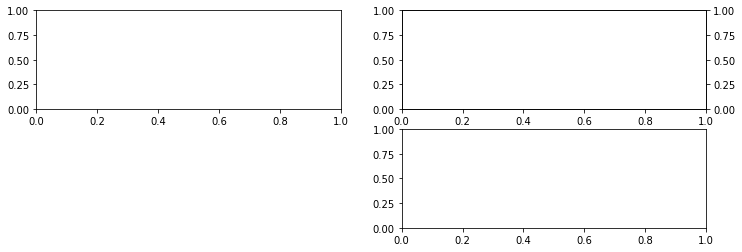

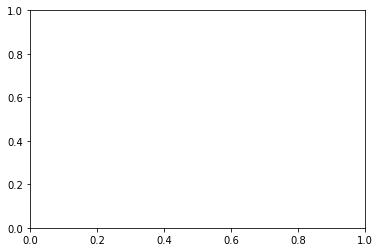

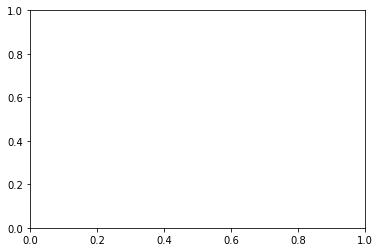

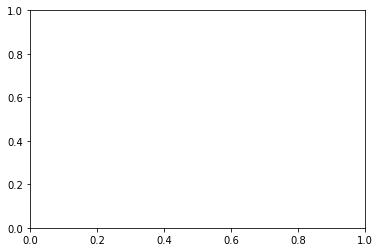

In [15]:
p = Population(**conf);

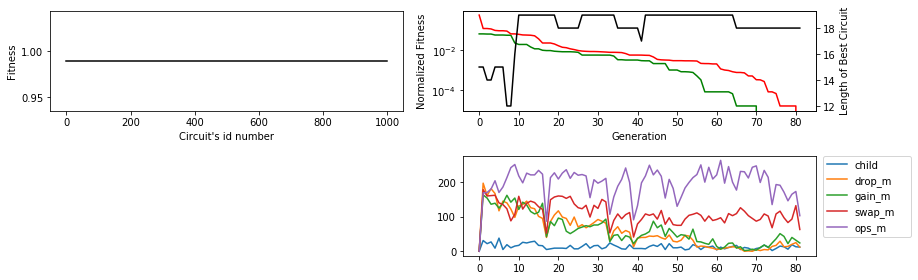

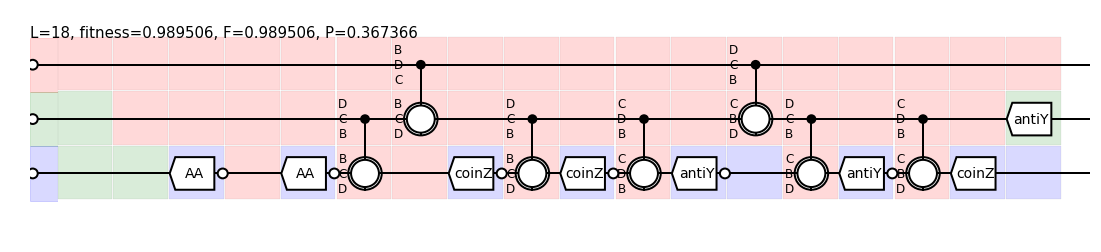

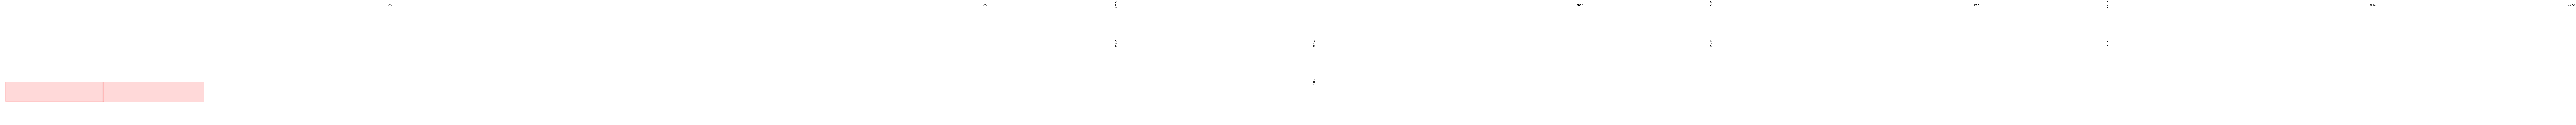

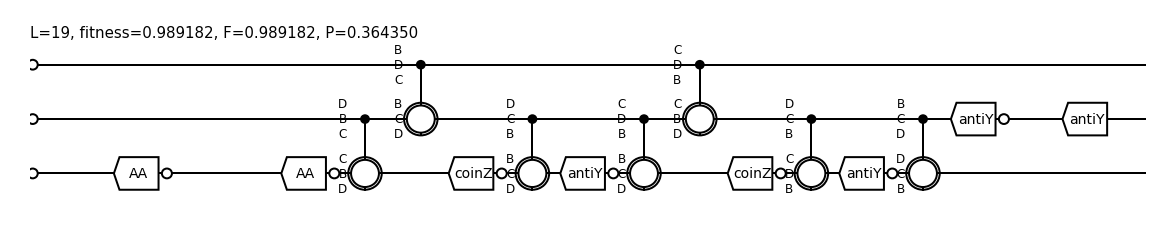

Generation: 81    Population: 1000    Δ: 0.000000e+00
The difference between best and worst is less than 1.000000e-15. Quiting.


In [16]:
p.run()

In [17]:
p.l[0].fidelity_and_succ_prob()

(0.9895058226709049, 0.36736629032846707)

In [18]:
p.l[0]

Individual(F=0.9, history=History.survivor, weights=(1, 0), ops=[
           SWAP([1, 2], 3, 0.99),
           SWAP([0, 1], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),
           SWAP([1, 2], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 3, 2, 1], [0, 1, 2, 3], 3, 0.99),
           CNOTPermNeigh([0, 1], [0, 1, 3, 2], [0, 1, 2, 3], 3, 0.99),
           AMeasurementNoReset(2, 3, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 3, 2, 1], [0, 1, 2, 3], 3, 0.99),
           AMeasurementNoReset(2, 3, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 2, 3, 1], [0, 2, 3, 1], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], [0, 3, 2, 1], [0, 2, 1, 3], 3, 0.99),
           CNOTPermNeigh([1, 2], [0, 3, 2, 1], [0, 2, 1, 3], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 2, 3, 1], [0, 2, 1, 3], 3, 0.99),
           AMeasureme

In [19]:
print(str(p.l[0]))

----x-------------*o-------------------------*o-------------------------
-x--x-----x----*o-*X-------*o-------*o-------*X-*o-------*o--------D01 >
-x-----#>-x--#>*X-----D03 >*X--D03 >*X--D01 >---*X--D01 >*X--D03 >------


In [20]:
print(str(nigmatullin))

----------------x----------------*o----------------*o-------------
-x-----o--------x--x-----o-------*X--D03 >-x-----o-*X--------D03 >
-x--#>-X--D03 >----x--#>-X--D03 >----------x--#>-X-----D03 >------


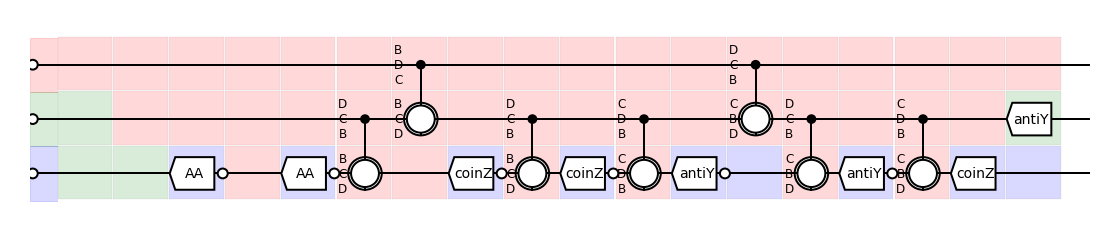

In [21]:
individual2plot(p.l[0], shading=True);

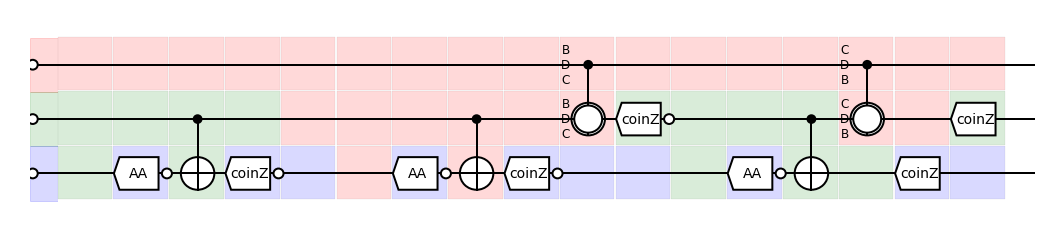

In [22]:
individual2plot(nigmatullin, shading=True);

In [23]:
p.l[0].fidelity_and_succ_prob(), nigmatullin.fidelity_and_succ_prob()

((0.9895058226709049, 0.36736629032846707),
 (0.975445210834237, 0.43194787567430243))

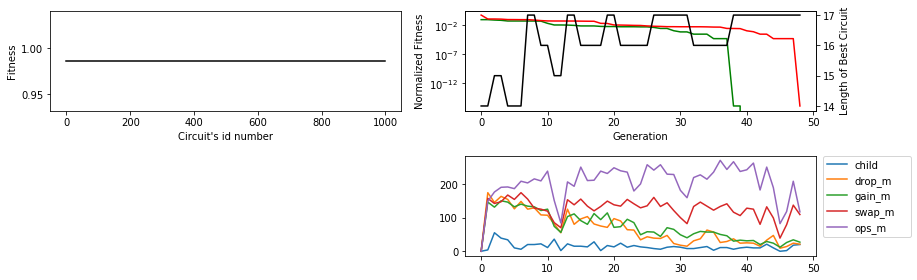

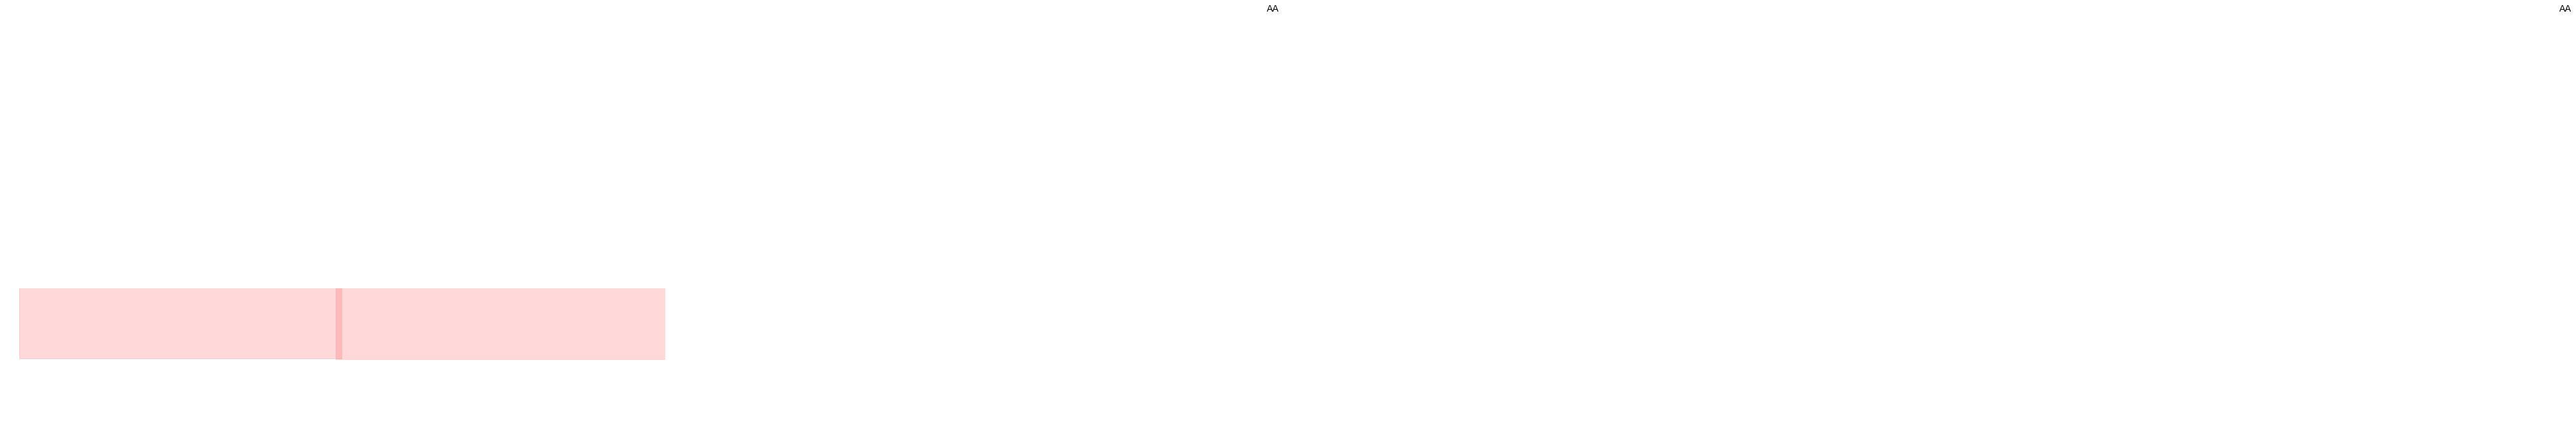

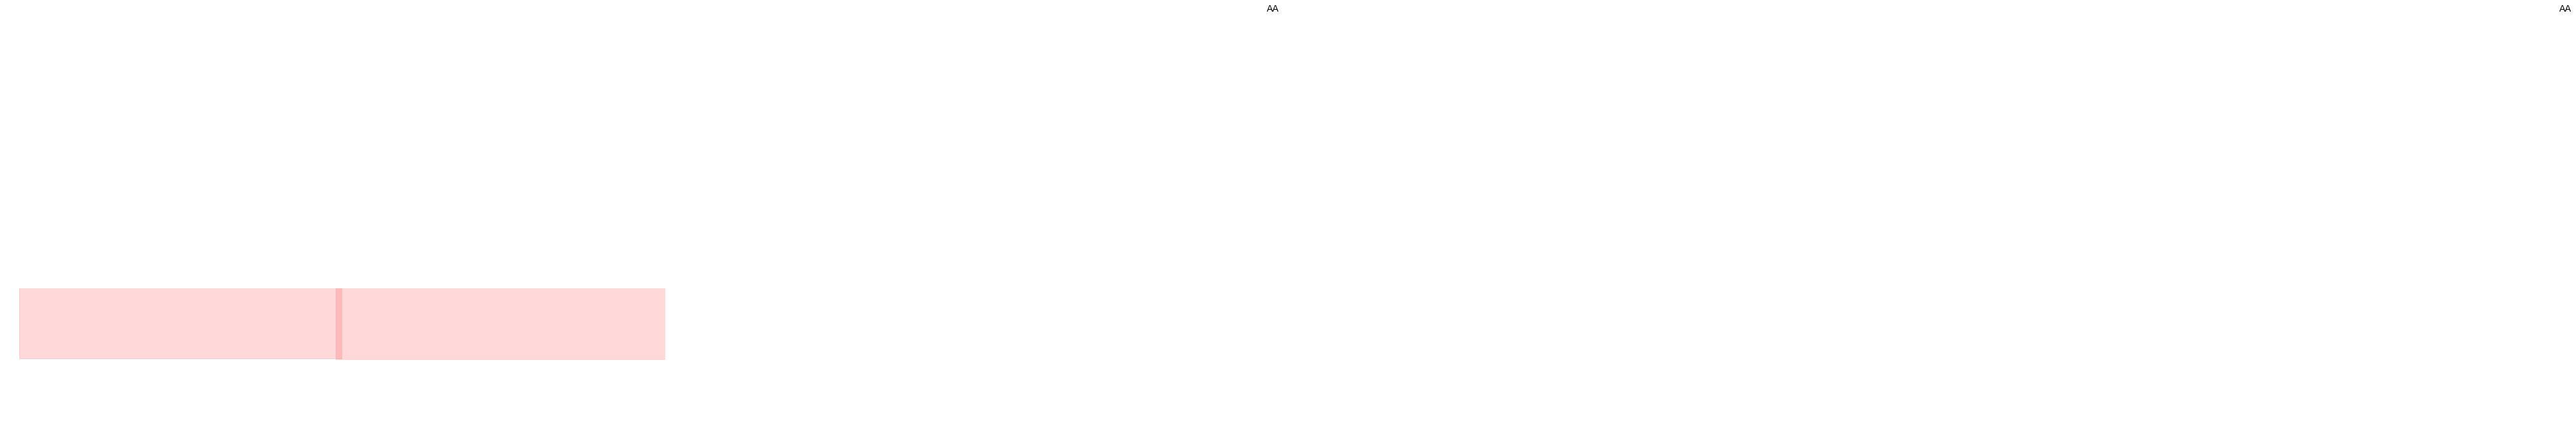

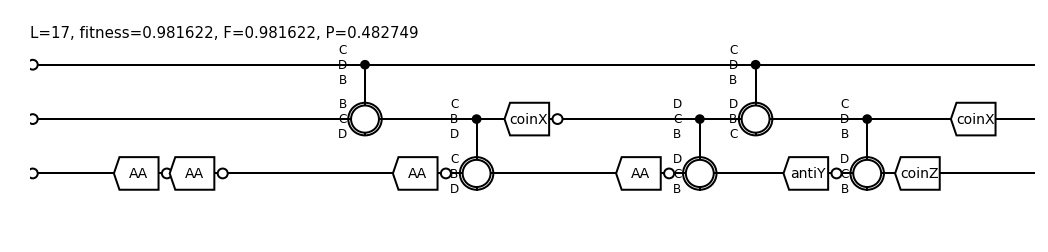

Generation: 48    Population: 1000    Δ: 1.110223e-16
The difference between best and worst is less than 1.000000e-15. Quiting.


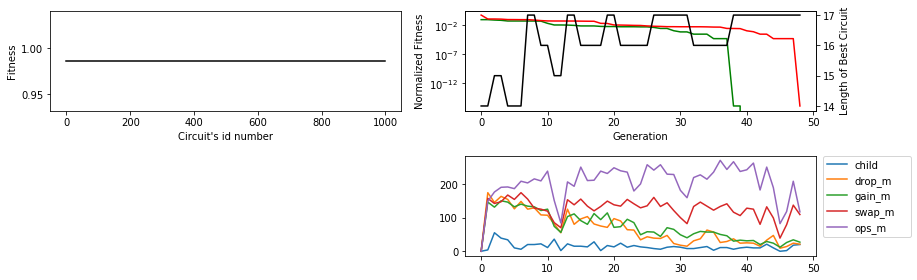

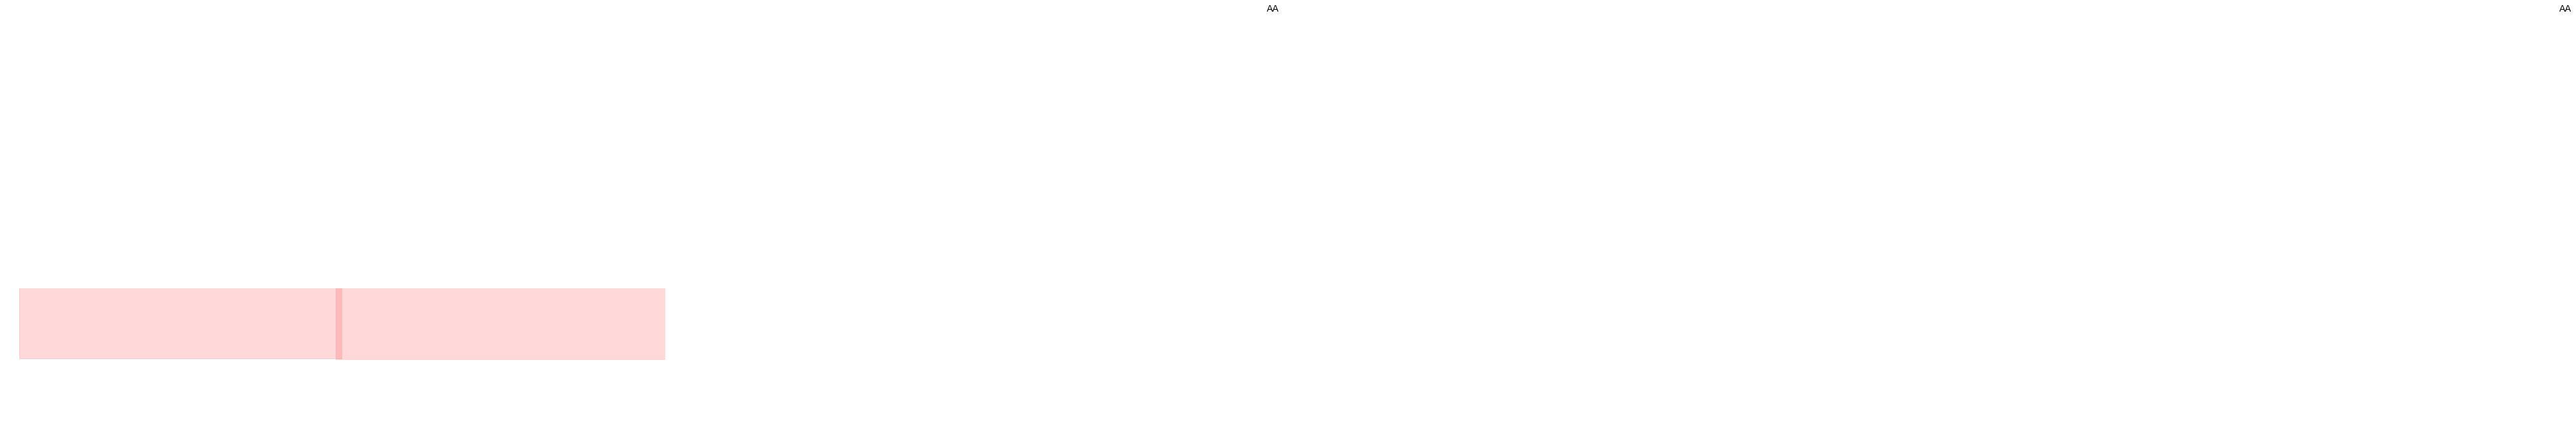

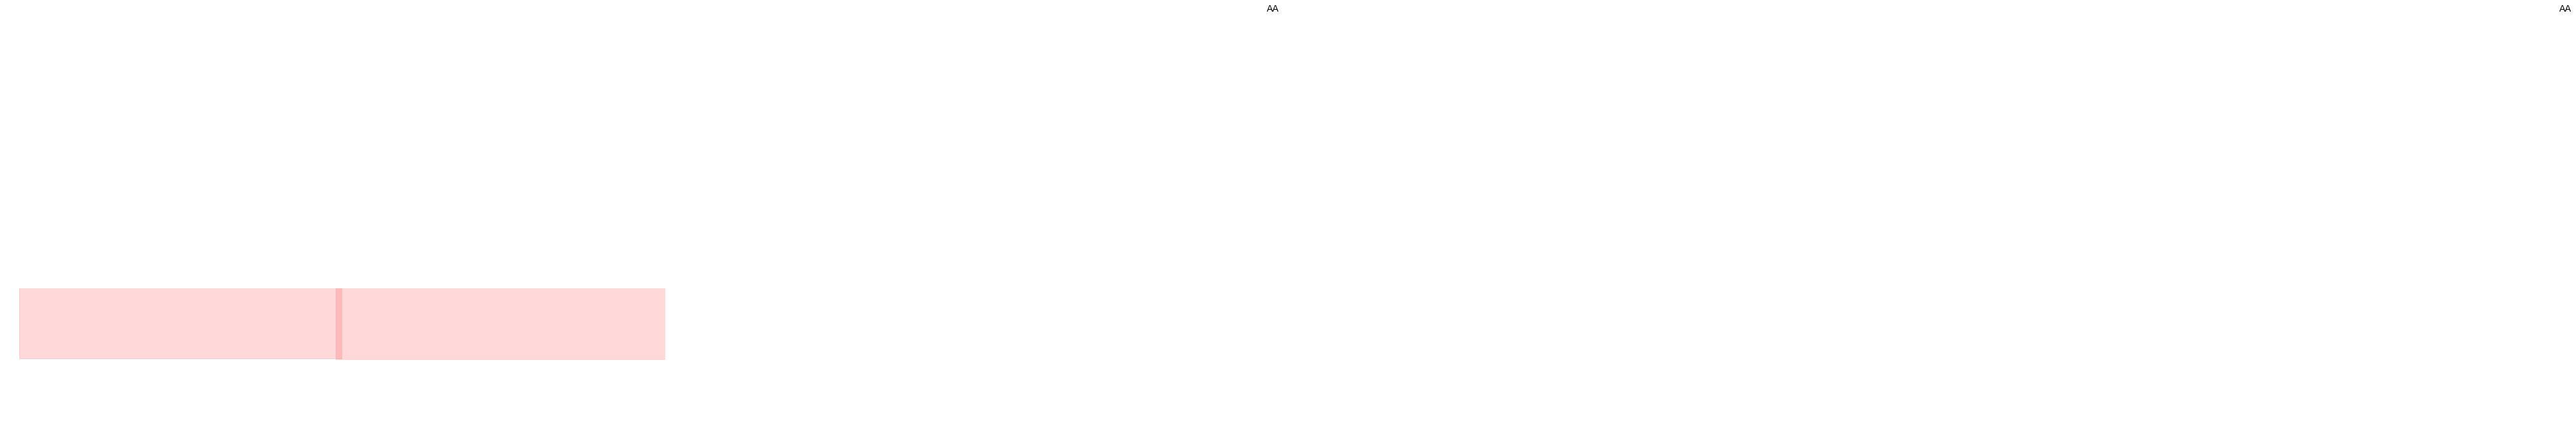

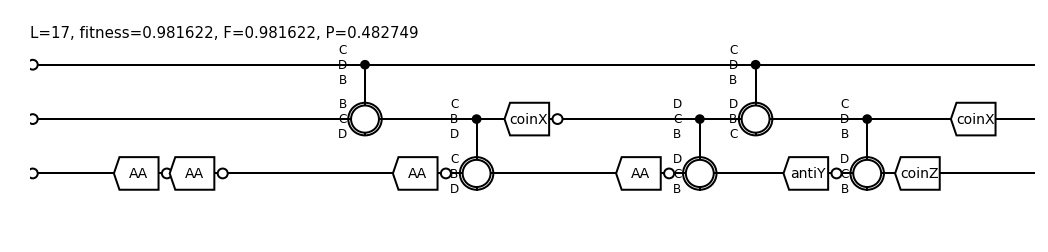

In [24]:
conf = default_config.copy()
conf['MAX_OPS'] = 17
conf['STARTING_OPS'] = 14
conf['N'] = 3
conf['POPULATION_SIZE'] = 1000
conf['STARTING_POP_MULTIPLIER'] = 10
conf['MAX_GEN'] = 2000
conf['PERMITTED_OPS'] = [CNOTPermNeigh, AMeasurementNoReset, SWAP, ComReset]
conf
p2 = Population(**conf);
p2.run()

In [25]:
p2.l[0].fidelity_and_succ_prob()

(0.9895058226709049, 0.36736629032846707)

In [26]:
p2.l[0]

Individual(F=0.9, history=History.survivor, weights=(1, 0), ops=[
           SWAP([1, 2], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),
           SWAP([0, 1], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),
           SWAP([1, 2], 3, 0.99),
           CNOTPermNeigh([0, 1], [0, 3, 1, 2], [0, 2, 3, 1], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 1, 2, 3], [0, 1, 3, 2], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 3, 2, 1], [0, 3, 1, 2], 3, 0.99),
           AMeasurementNoReset(2, 3, 3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], (0, 1, 3, 2), (0, 1, 2, 3), 3, 0.99),
           CNOTPermNeigh([1, 2], [0, 3, 2, 1], [0, 1, 3, 2], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 1, 3, 2], [0, 1, 3, 2], 3, 0.99),
           AMeasurementNoReset(1, 1, 3, 0.9, 0.99, None),
           AMeasurementNoReset(2, 3, 3, 0.9, 0.99, 

In [27]:
print(str(p2.l[0]))

-------x-------*o----------------------*o-------------------------
-x-----x-----x-*X----*o-------*o-------*X-*o-------*o--D01 >------
-x--#>----#>-x-----#>*X--D01 >*X--D03 >---*X--D01 >*X--------D03 >


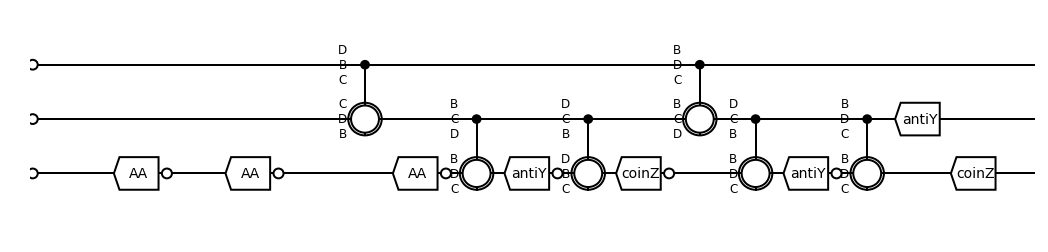

In [30]:
individual2plot(p2.l[0]);

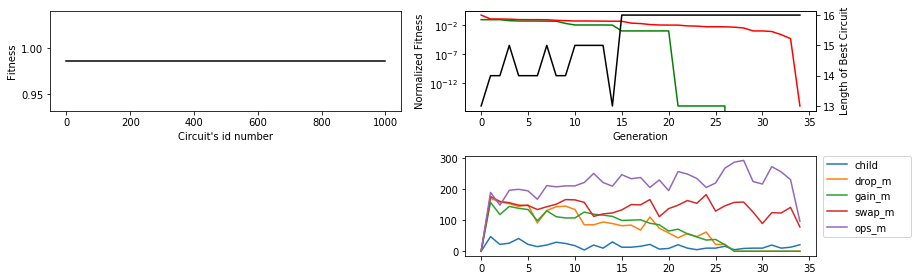

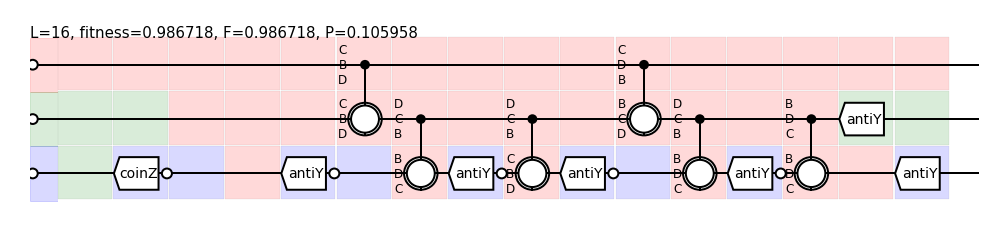

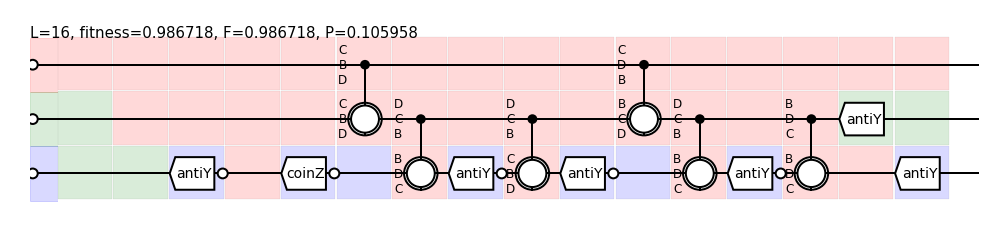

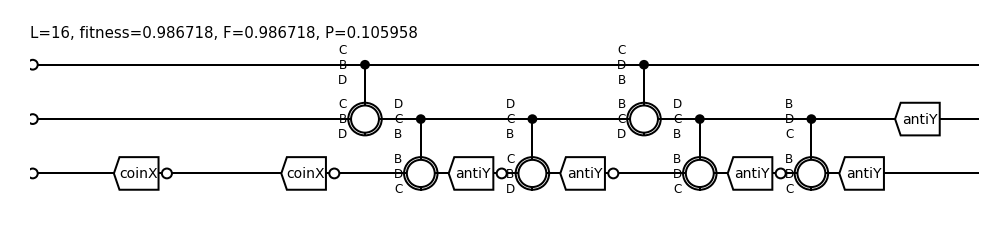

Generation: 34    Population: 1000    Δ: 1.110223e-16
The difference between best and worst is less than 1.000000e-15. Quiting.


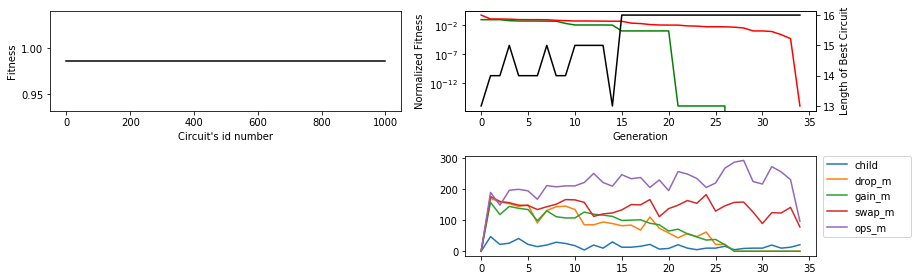

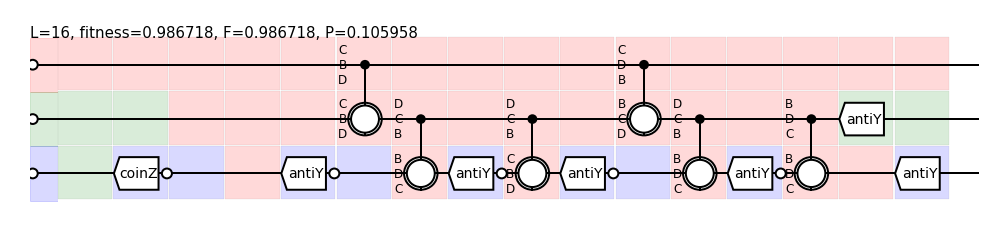

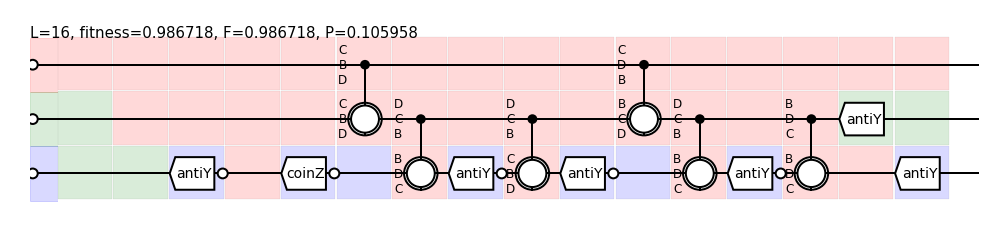

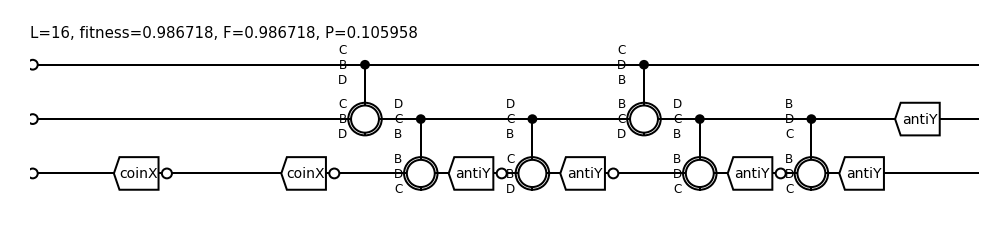

In [45]:
conf = default_config.copy()
conf['MAX_OPS'] = 16
conf['STARTING_OPS'] = 13
conf['N'] = 3
conf['POPULATION_SIZE'] = 1000
conf['STARTING_POP_MULTIPLIER'] = 10
conf['MAX_GEN'] = 2000
conf['PERMITTED_OPS'] = [CNOTPermNeigh, AMeasurementNoReset, SWAP, ComReset]
conf
p3 = Population(**conf);
p3.run()

In [46]:
p3.l[0].fidelity_and_succ_prob()

(0.9867178060753331, 0.10595828178742774)

In [48]:
p3.l[0]

Individual(F=0.9, history=History.survivor, weights=(1, 0), ops=[
           SWAP([1, 2], 3, 0.99),
           AMeasurementNoReset(2, 3, 3, 0.9, 0.99, None),
           SWAP([0, 1], 3, 0.99),
           SWAP([1, 2], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], [0, 2, 1, 3], [0, 2, 1, 3], 3, 0.99),
           CNOTPermNeigh([1, 2], (0, 3, 2, 1), (0, 1, 3, 2), 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], (0, 3, 2, 1), (0, 2, 1, 3), 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], [0, 2, 3, 1], [0, 1, 2, 3], 3, 0.99),
           CNOTPermNeigh([1, 2], (0, 3, 2, 1), (0, 1, 3, 2), 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 1, 3, 2], [0, 1, 3, 2], 3, 0.99),
           AMeasurementNoReset(1, 1, 3, 0.9, 0.99, None),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None)])

In [49]:
print(str(p3.l[0]))

----------x----------*o-------------------*o-------------------------
-x--------x--x-------*X-*o-------*o-------*X-*o-------*o--D01 >------
-x--D03 >----x--D01 >---*X--D01 >*X--D01 >---*X--D01 >*X--------D01 >


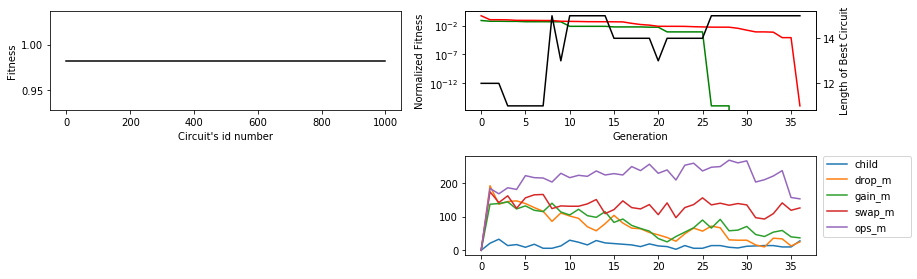

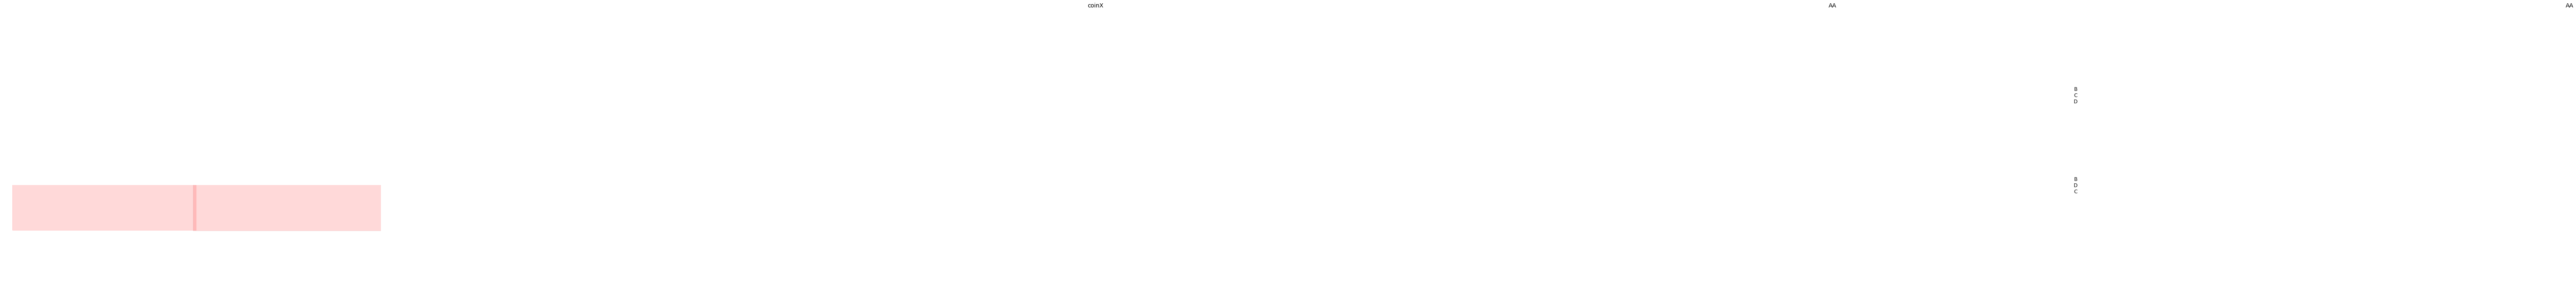

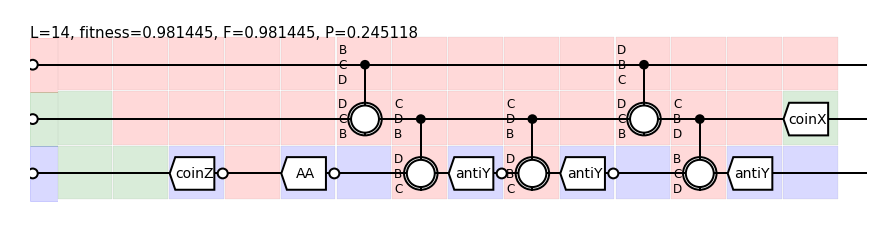

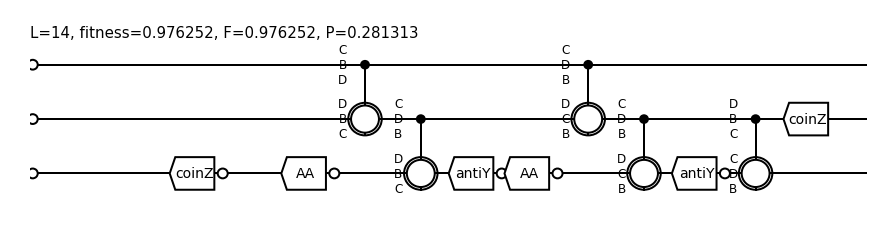

Generation: 36    Population: 1000    Δ: 1.110223e-16
The difference between best and worst is less than 1.000000e-15. Quiting.


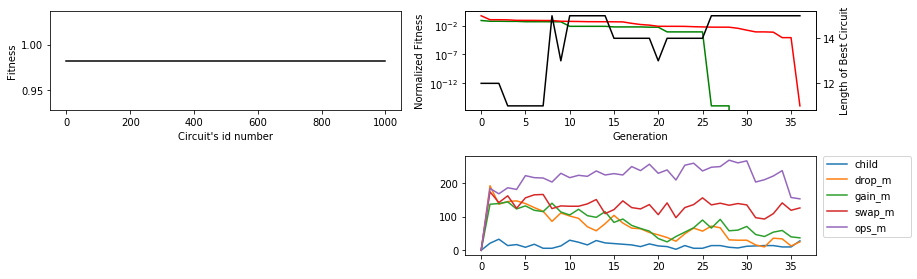

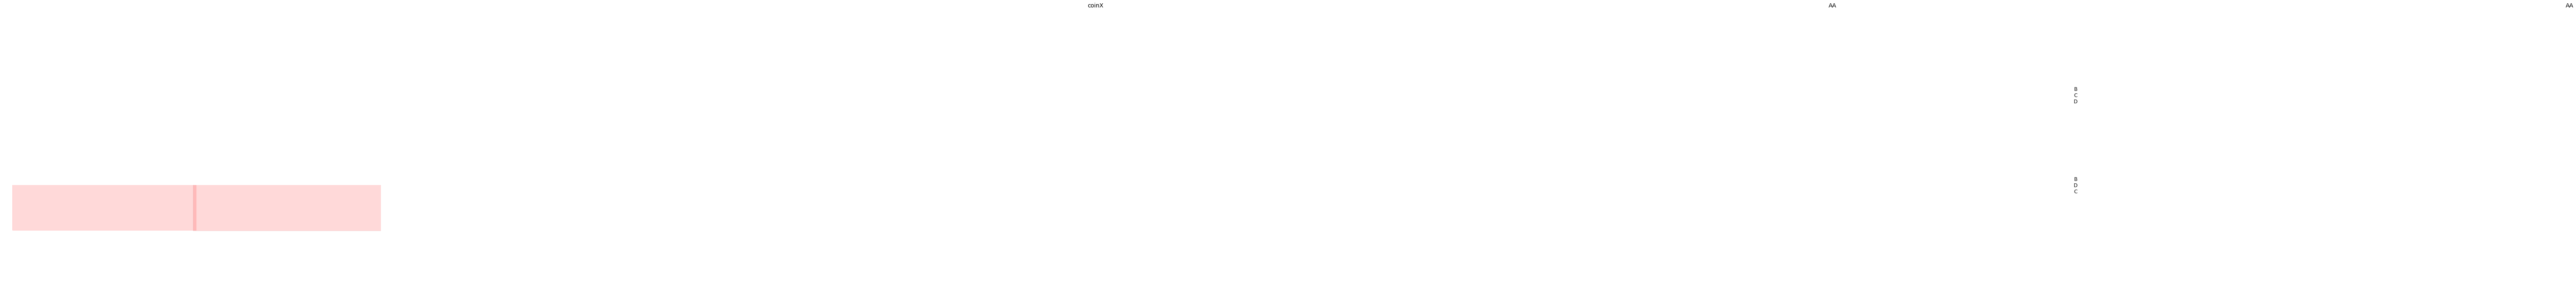

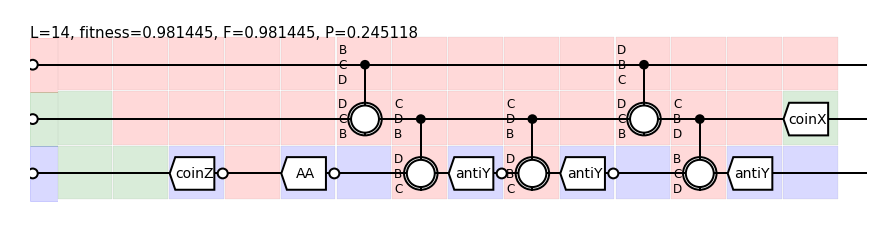

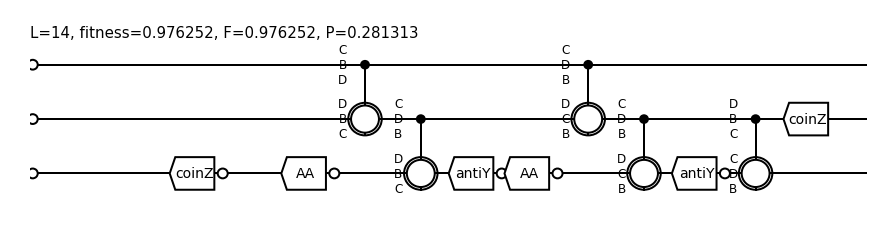

In [14]:
conf = default_config.copy()
conf['MAX_OPS'] = 15
conf['STARTING_OPS'] = 12
conf['N'] = 3
conf['POPULATION_SIZE'] = 1000
conf['STARTING_POP_MULTIPLIER'] = 10
conf['MAX_GEN'] = 2000
conf['PERMITTED_OPS'] = [CNOTPermNeigh, AMeasurementNoReset, SWAP, ComReset]
conf
p4 = Population(**conf);
p4.run()

In [15]:
p4.l[0].fidelity_and_succ_prob()

(0.9822630427655967, 0.24488543027026746)

In [16]:
p4.l[0]

Individual(F=0.9, history=History.survivor, weights=(1, 0), ops=[
           SWAP([1, 2], 3, 0.99),
           SWAP([0, 1], 3, 0.99),
           AMeasurementNoReset(2, 2, 3, 0.9, 0.99, None),
           SWAP([1, 2], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], [0, 1, 3, 2], [0, 1, 2, 3], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 2, 3, 1], [0, 3, 1, 2], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 3, 1, 2], [0, 3, 2, 1], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], [0, 3, 1, 2], [0, 3, 2, 1], 3, 0.99),
           CNOTPermNeigh([1, 2], [0, 2, 1, 3], [0, 1, 2, 3], 3, 0.99),
           AMeasurementNoReset(1, 2, 3, 0.9, 0.99, None),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None)])

In [17]:
print(str(p4.l[0]))

----x-------------*o----------------------*o----------------
-x--x--------x----*X----*o-------*o-------*X-*o--D02 >------
-x-----D02 >-x--#>----#>*X--D01 >*X--D01 >---*X--------D01 >


We can copy the best results and see whether any manual cleanup is necessary (our set of canonicalization operations are not customized for the hot-cold type of register we are using here).

In [36]:
c18 = Individual(F=0.9, ops=[
           SWAP([1, 2], 3, 0.99),
           SWAP([0, 1], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),
           SWAP([1, 2], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 3, 2, 1], [0, 1, 2, 3], 3, 0.99),
           CNOTPermNeigh([0, 1], [0, 1, 3, 2], [0, 1, 2, 3], 3, 0.99),
           AMeasurementNoReset(2, 3, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 3, 2, 1], [0, 1, 2, 3], 3, 0.99),
           AMeasurementNoReset(2, 3, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 2, 3, 1], [0, 2, 3, 1], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], [0, 3, 2, 1], [0, 2, 1, 3], 3, 0.99),
           CNOTPermNeigh([1, 2], [0, 3, 2, 1], [0, 2, 1, 3], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 2, 3, 1], [0, 2, 1, 3], 3, 0.99),
           AMeasurementNoReset(2, 3, 3, 0.9, 0.99, None),
           AMeasurementNoReset(1, 1, 3, 0.9, 0.99, None)])
print(str(c18))
c18.fidelity_and_succ_prob()

----x-------------*o-------------------------*o-------------------------
-x--x-----x----*o-*X-------*o-------*o-------*X-*o-------*o--------D01 >
-x-----#>-x--#>*X-----D03 >*X--D03 >*X--D01 >---*X--D01 >*X--D03 >------


(0.9895058226709049, 0.36736629032846707)

In [37]:
c17 = Individual(F=0.9, ops=[
           SWAP([1, 2], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),
           SWAP([0, 1], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),
           SWAP([1, 2], 3, 0.99),
           CNOTPermNeigh([0, 1], [0, 3, 1, 2], [0, 2, 3, 1], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 1, 2, 3], [0, 1, 3, 2], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 3, 2, 1], [0, 3, 1, 2], 3, 0.99),
           AMeasurementNoReset(2, 3, 3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], (0, 1, 3, 2), (0, 1, 2, 3), 3, 0.99),
           CNOTPermNeigh([1, 2], [0, 3, 2, 1], [0, 1, 3, 2], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 1, 3, 2], [0, 1, 3, 2], 3, 0.99),
           AMeasurementNoReset(1, 1, 3, 0.9, 0.99, None),
           AMeasurementNoReset(2, 3, 3, 0.9, 0.99, None)])
print(str(c17))
c17.fidelity_and_succ_prob()

-------x-------*o----------------------*o-------------------------
-x-----x-----x-*X----*o-------*o-------*X-*o-------*o--D01 >------
-x--#>----#>-x-----#>*X--D01 >*X--D03 >---*X--D01 >*X--------D03 >


(0.9867178060753331, 0.42383312714971094)

The third circuit we generated has an obviously unnecessary measurement. It is because with the current cost function (not taking success probability into account) a measurement and just a reset have the same effect. We can just change the cost function or we can also fixe it manually.

In [50]:
c16 = Individual(F=0.9, ops=[
           SWAP([1, 2], 3, 0.99),
           AMeasurementNoReset(2, 3, 3, 0.9, 0.99, None),
           SWAP([0, 1], 3, 0.99),
           SWAP([1, 2], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], [0, 2, 1, 3], [0, 2, 1, 3], 3, 0.99),
           CNOTPermNeigh([1, 2], (0, 3, 2, 1), (0, 1, 3, 2), 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], (0, 3, 2, 1), (0, 2, 1, 3), 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], [0, 2, 3, 1], [0, 1, 2, 3], 3, 0.99),
           CNOTPermNeigh([1, 2], (0, 3, 2, 1), (0, 1, 3, 2), 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 1, 3, 2], [0, 1, 3, 2], 3, 0.99),
           AMeasurementNoReset(1, 1, 3, 0.9, 0.99, None),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None)])
c16fixed = Individual(F=0.9, ops=[
           SWAP([1, 2], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),# This one should be a reset instead of a measurement AMeasurementNoReset(2, 3, 3, 0.9, 0.99, None),
           SWAP([0, 1], 3, 0.99),
           SWAP([1, 2], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),# This one should be a reset instead of a measurement AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], [0, 2, 1, 3], [0, 2, 1, 3], 3, 0.99),
           CNOTPermNeigh([1, 2], (0, 3, 2, 1), (0, 1, 3, 2), 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], (0, 3, 2, 1), (0, 2, 1, 3), 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], [0, 2, 3, 1], [0, 1, 2, 3], 3, 0.99),
           CNOTPermNeigh([1, 2], (0, 3, 2, 1), (0, 1, 3, 2), 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 1, 3, 2], [0, 1, 3, 2], 3, 0.99),
           AMeasurementNoReset(1, 1, 3, 0.9, 0.99, None),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None)])
print(str(c16fixed))
c16.fidelity_and_succ_prob(), c16fixed.fidelity_and_succ_prob()

-------x-------*o-------------------*o-------------------------
-x-----x--x----*X-*o-------*o-------*X-*o-------*o--D01 >------
-x--#>----x--#>---*X--D01 >*X--D01 >---*X--D01 >*X--------D01 >


((0.9867178060753331, 0.10595828178742774),
 (0.9867178060753331, 0.42383312714971094))

In [25]:
c15 = Individual(F=0.9, ops=[
           SWAP([1, 2], 3, 0.99),
           SWAP([0, 1], 3, 0.99),
           AMeasurementNoReset(2, 2, 3, 0.9, 0.99, None),
           SWAP([1, 2], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], [0, 1, 3, 2], [0, 1, 2, 3], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 2, 3, 1], [0, 3, 1, 2], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 3, 1, 2], [0, 3, 2, 1], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], [0, 3, 1, 2], [0, 3, 2, 1], 3, 0.99),
           CNOTPermNeigh([1, 2], [0, 2, 1, 3], [0, 1, 2, 3], 3, 0.99),
           AMeasurementNoReset(1, 2, 3, 0.9, 0.99, None),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None)])
c15fixed = Individual(F=0.9, ops=[
           SWAP([1, 2], 3, 0.99),
           SWAP([0, 1], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),# This one should be a reset instead of a measurement AMeasurementNoReset(2, 2, 3, 0.9, 0.99, None),
           SWAP([1, 2], 3, 0.99),
           ComReset(3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], [0, 1, 3, 2], [0, 1, 2, 3], 3, 0.99),
           # Not necessary at all ComReset(3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 2, 3, 1], [0, 3, 1, 2], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([1, 2], [0, 3, 1, 2], [0, 3, 2, 1], 3, 0.99),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None),
           CNOTPermNeigh([0, 1], [0, 3, 1, 2], [0, 3, 2, 1], 3, 0.99),
           CNOTPermNeigh([1, 2], [0, 2, 1, 3], [0, 1, 2, 3], 3, 0.99),
           AMeasurementNoReset(1, 2, 3, 0.9, 0.99, None),
           AMeasurementNoReset(2, 1, 3, 0.9, 0.99, None)])
print(str(c15fixed))
c15.fidelity_and_succ_prob(), c15fixed.fidelity_and_succ_prob()

----x----------*o-------------------*o----------------
-x--x-----x----*X-*o-------*o-------*X-*o--D02 >------
-x-----#>-x--#>---*X--D01 >*X--D01 >---*X--------D01 >


((0.9822630427655967, 0.24488543027026746),
 (0.9822630427655967, 0.4897708605405349))

In [51]:
nigmatullin.fidelity_and_succ_prob()

(0.975445210834237, 0.43194787567430243)

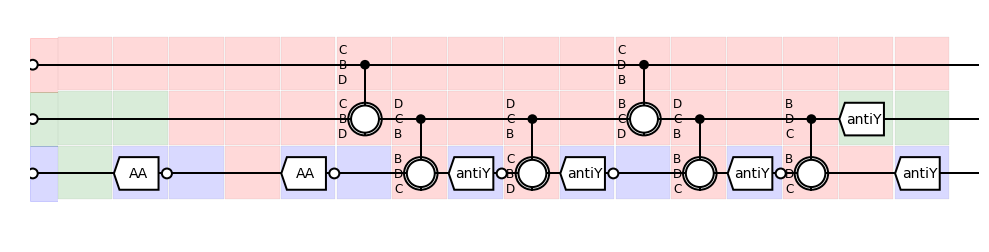

In [53]:
individual2plot(c16fixed, shading=True);

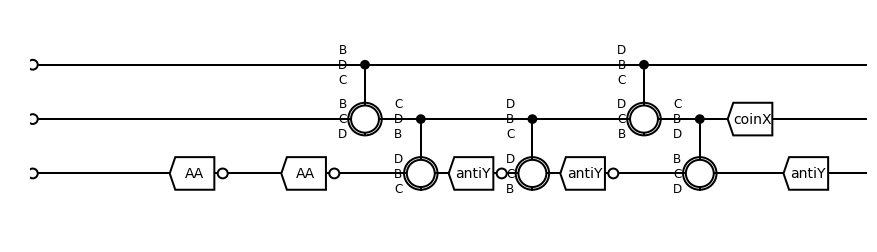

In [26]:
individual2plot(c15fixed); # there is a bug with the shading

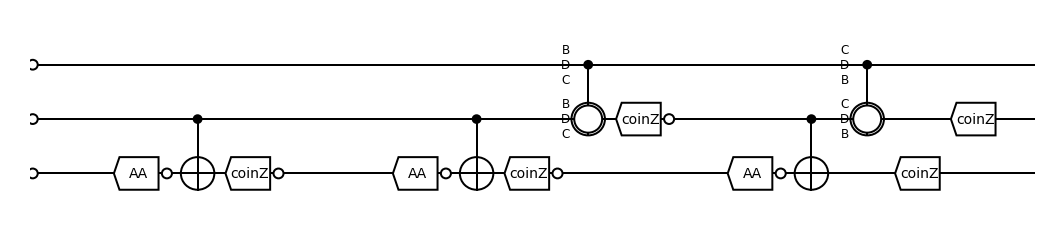

In [24]:
individual2plot(nigmatullin);

In [56]:
print(str(c16fixed))

-------x-------*o-------------------*o-------------------------
-x-----x--x----*X-*o-------*o-------*X-*o-------*o--D01 >------
-x--#>----x--#>---*X--D01 >*X--D01 >---*X--D01 >*X--------D01 >


In [27]:
print(str(c15fixed))

----x----------*o-------------------*o----------------
-x--x-----x----*X-*o-------*o-------*X-*o--D02 >------
-x-----#>-x--#>---*X--D01 >*X--D01 >---*X--------D01 >


In [55]:
print(str(nigmatullin))

----------------x----------------*o----------------*o-------------
-x-----o--------x--x-----o-------*X--D03 >-x-----o-*X--------D03 >
-x--#>-X--D03 >----x--#>-X--D03 >----------x--#>-X-----D03 >------
